# Model Evaluation and Refinement
---------------------------------

This notebook will discuss some techniques on how to evaluate models and a way to refine the Linear Regression Models.

After creating a model, it is vital to evaluate it for correctness and refine if necessary. There are various ways to do so.

We would be discussing some common ways to do so in here. 

We would be trying to evaluate models that aim to predict the price of the car.

This is based on the IBM's Course on Data Analysis with Python.

We would be creating some simple models to demonstrate the techniques but they can be used on complex models.  

First, let's do the necessary setup.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
%matplotlib inline

Now, we will get the data.

In [2]:
path = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-SkillsNetwork/labs/Data%20files/module_5_auto.csv'
df = pd.read_csv(path)

For our models, we would be using only the numeric data.

In [3]:
df=df._get_numeric_data()
df.head()

Unnamed: 0  Unnamed: 0.1  symboling  normalized-losses  wheel-base  \
0           0             0          3                122        88.6   
1           1             1          3                122        88.6   
2           2             2          1                122        94.5   
3           3             3          2                164        99.8   
4           4             4          2                164        99.4   

     length     width  height  curb-weight  engine-size  ...  stroke  \
0  0.811148  0.890278    48.8         2548          130  ...    2.68   
1  0.811148  0.890278    48.8         2548          130  ...    2.68   
2  0.822681  0.909722    52.4         2823          152  ...    3.47   
3  0.848630  0.919444    54.3         2337          109  ...    3.40   
4  0.848630  0.922222    54.3         2824          136  ...    3.40   

   compression-ratio  horsepower  peak-rpm  city-mpg  highway-mpg    price  \
0                9.0       111.0    5000.0        21           27  13495.0   
1                9.0       111.0    5000.0        21           27  16500.0   
2                9.0       154.0    5000.0        19           26  16500.0   
3               10.0       102.0    5500.0        24           30  13950.0   
4                8.0       115.0    5500.0        18           22  17450.0   

   city-L/100km  diesel  gas  
0     11.190476       0    1  
1     11.190476       0    1  
2     12.368421       0    1  
3      9.791667       0    1  
4     13.055556       0    1  

[5 rows x 21 columns]

# Training and Testing

By training and testing, we refer to splitting your data into two componenets: one for training and another for testing. 

This is a very important step since we can test our data pre-liminarily on 'unkown' values. The split generally depends on the problem but the test data tends to be between 10% to 30% of the total data. 

First, let's create our X and y. 

In [4]:
y = df['price']

For X, let's take everything except price.

In [5]:
X = df.drop('price', axis=1)

The next step is to split them into training and testing. 

It's highly recommended to do so in a random manner. 

To make our jobs easier, we would be using `train_test_split` from `model_selection` module in scikit-learn. To use the function, we pass in the X and y, the test size and a random_state variable. The `random_state` variable is used when applying the random function. This will allow us to reproduce the results.  

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1)

print("number of test samples :", X_test.shape[0])
print("number of training samples:",X_train.shape[0])

number of test samples : 21
number of training samples: 180


Let's create a simple linear regression model with horsepower as the predictor. 

In [7]:
from sklearn.linear_model import LinearRegression
lre=LinearRegression()
lre.fit(X_train[['horsepower']], y_train)

LinearRegression()

# Evaluation with metrics
A good way to test the model is to use metrics. There are different metrics suitable for different situations. Let's classify them based on the problem type.

## Regression
Common metrics are R-squared and Root Mean Squared Error (RMSE). 

* R-squared tells how close the data is to the linear regression line. It typically ranges from 0 to 1 with 1 being the highest; however it can be negative if the model is worse. 
* RMSE (and other metrics such as MAE or MSE) give an account of the error. RMSE takes the root of the sum of error squares. 

## Classification
Common metrics are Jaccard Index, Precision, Recall, and F1-Score.
* Jaccard Index tells us how 'accurate' the model. Essentially, the proportion of correctly predicted values. It is defined as the ratio of intersection (or the same values aka correct predictions) and union (all values).
* Precision talks about how precise your model is. That is, out of the predicted positive, how many of them are actual positives.
* Recall talks about how many of the Actual Positives our model captures via labeling them as Positive (True Positive)
* F1 Score is the harmonic mean of Precision and Recall. It's used when we need a balance between Precision and Recall. F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall AND there is an uneven class distribution (large number of Actual Negatives). For example, if a positive means a terrorist and there a few positives, then we should use F1 Score because the cost of not capturing a terrorist is much higher than correctly identifying a civilian.

## Calculation
There are multiple ways to calculate them. 

You can use the metrics in `sklearn.metrics.` You choose the desired metric function and pass in the true _y_ and predicted _y_. The function then returns back the metric.

We can also use the inherent `score` method built-in some of the objects by scikit-learn. 

In `LinearRegression`, it calculates the R^2 on the test data:

In [8]:
lre.score(X_test[['horsepower']], y_test)

0.3635875575078824

For the training data:

In [9]:
lre.score(X_train[['horsepower']], y_train)

0.6619724197515103

This is not ideal at all. Furthermore, you might have realized that the scoring could depend heavily on the split too. For some splits, the metrics could be very different. For eg, if you change the random_state in the splitting to 0, the R-squared changes to around 0.74!

Furthermore, the dataset we have is not that large. We would need a better way to conduct tests. 

This is where k-fold cross-validation comes in.

# K-Fold Cross-validation

From [Machine Learning Mastery](https://machinelearningmastery.com/k-fold-cross-validation/):

Cross-validation is a statistical method used to estimate the skill of machine learning models.

The general procedure is as follows:
* Shuffle the dataset randomly.
* Split the dataset into k groups
* For each unique group:
	- Take the group as a hold out or test data set
	- Take the remaining groups as a training data set
	- Fit a model on the training set and evaluate it on the test set
	- Retain the evaluation score and discard the model
* Summarize the skill of the model using the sample of model evaluation scores

As you can see, it is a very valuable and useful technique. Fortunately, sklearn has modules to makes our job easier. 

To do cross-validation, we need to import the `cross_val_score` from `sklearn.model_selection`

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

To use it, we would need to pass the _model_, _X_, _y_, and the number of folds as _cv_.

In [11]:
Rcross = cross_val_score(estimator=lre, X=X[['horsepower']], y=y, cv=4)

If we pass in nothing, the scorer would use the default scoring function of the estimator. The function returns an ndarray with each element containing the R-squared value for the fold run. We can see all the values by:

In [12]:
Rcross

array([0.7746232 , 0.51716687, 0.74785353, 0.04839605])

## Getting the descriptive statistics

After getting the array, it's useful to calculate descriptive statistics such as the five number summary. 

For the average and standard deviation. We can do just call the methods that are built-in:

In [13]:
print("The mean of the folds are", Rcross.mean(), "and the standard deviation is" , Rcross.std())

The mean of the folds are 0.522009915042119 and the standard deviation is 0.2911839444756029


Here's a little hack to get the five number summary. We convert it to a panda series and then call the function describe on it.  

In [14]:
pd.Series(Rcross).describe()

count    4.000000
mean     0.522010
std      0.336230
min      0.048396
25%      0.399974
50%      0.632510
75%      0.754546
max      0.774623
dtype: float64

## Getting different metrics

If you want a different metric, simply pass on a string for it. To check what's available, we need to import `SCORERS` from `sklearn.metrics`. 

Then we can use `SCORERS.keys`. Having it sorted is also helpful.

In [15]:
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

Here's how to get RMSE. Since the one here has negative, we need to multiple it by -1 to get the array of RMSEs.

In [16]:
-1 * cross_val_score(lre,X[['horsepower']], y,cv=4,scoring='neg_root_mean_squared_error')

array([4500.46029204, 6614.03759175, 3541.13404719, 4190.69537457])

# Overfitting, Underfitting and Model Selection

The test data, sometimes referred to as the out of sample data, is a much better measure of how well your model performs in the real world. One reason for this is overfitting - when the model is overfitted or overspecific to the training data. It turns out these differences are more apparent in Multiple Linear Regression and Polynomial Regression so we will explore overfitting in that context.

Let's create Multiple linear regression objects and train the model using 'horsepower', 'curb-weight', 'engine-size' and 'highway-mpg' as features.

In [18]:
lr = LinearRegression()
lr.fit(X_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_train)

LinearRegression()

In [19]:
yhat_train = lr.predict(X_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
yhat_train[0:5]

array([ 7426.6731551 , 28323.75090803, 14213.38819709,  4052.34146983,
       34500.19124244])

In [20]:
yhat_test = lr.predict(X_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
yhat_test[0:5]

array([11349.35089149,  5884.11059106, 11208.6928275 ,  6641.07786278,
       15565.79920282])

Let's perform some model evaluation using our training and testing data separately.

Let's examine the distribution of the predicted values of the training data. 

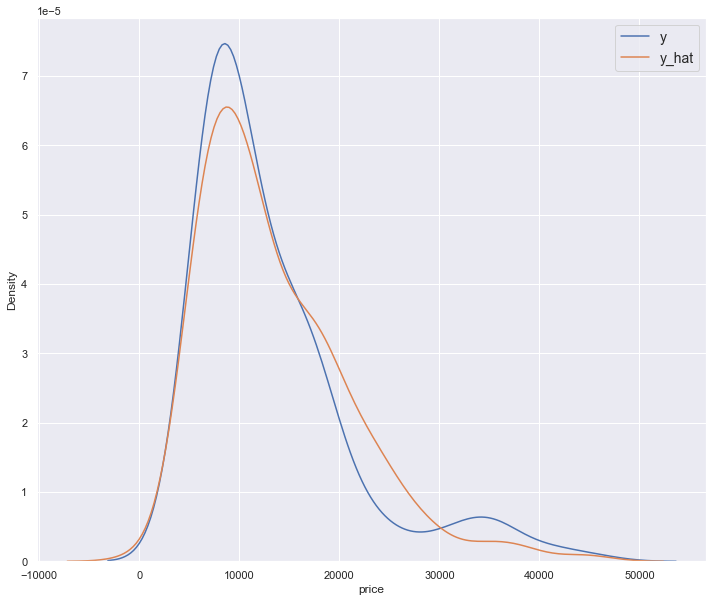

In [21]:
plt.figure(figsize=(12,10))
ax = sns.kdeplot(x=y)
sns.kdeplot(x=yhat_train, ax=ax)
ax.legend(['y', 'y_hat'], fontsize=14);

So far the model seems to be doing well in learning from the training dataset. But what happens when the model encounters new data from the testing dataset? When the model generates new values from the test data, we see the distribution of the predicted values is much different from the actual target values.

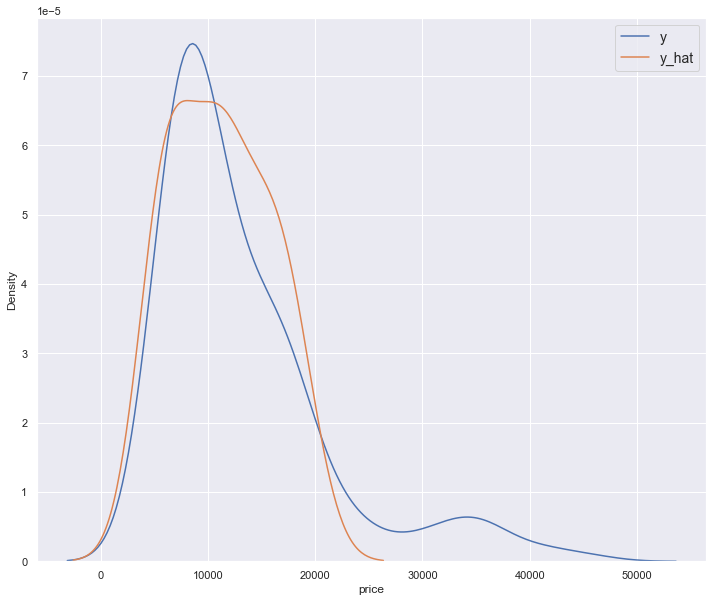

In [22]:
plt.figure(figsize=(12,10))
ax = sns.kdeplot(x=y)
sns.kdeplot(x=yhat_test, ax=ax)
ax.legend(['y', 'y_hat'], fontsize=14);

Comparing the Figures, it is evident the distribution of the test data in Figure 1 is much better at fitting the data.

Let's see if polynomial regression also exhibits a drop in the prediction accuracy when analysing the test dataset.

In [23]:
from sklearn.preprocessing import PolynomialFeatures

Overfitting occurs when the model fits the noise, not the underlying process. Therefore when testing your model using the test-set, your model does not perform as well as it is modelling noise, not the underlying process that generated the relationship. Let's create a degree 5 polynomial model.

Let's use 55 percent of the data for training and the rest for testing:


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.45, random_state=0)

We will perform a degree 5 polynomial transformation on the feature 'horse power'

In [25]:
pr = PolynomialFeatures(degree=5)
X_train_pr = pr.fit_transform(X_train[['horsepower']])
X_test_pr = pr.fit_transform(X_test[['horsepower']])
pr

PolynomialFeatures(degree=5)

Now let's create a linear regression model "poly" and train it.


In [26]:
poly = LinearRegression()
poly.fit(X_train_pr, y_train)

LinearRegression()

We can see the output of our model using the method  "predict." then assign the values to "yhat".


In [27]:
yhat = poly.predict(X_test_pr)
yhat[0:5]

array([ 6728.70501896,  7308.02845162, 12213.7843307 , 18893.19108677,
       19995.88963424])

Let's take the first five predicted values and compare it to the actual targets. 


In [28]:
print("Predicted values:", yhat[0:4])
print("True values:", y_test[0:4].values)

Predicted values: [ 6728.70501896  7308.02845162 12213.7843307  18893.19108677]
True values: [ 6295. 10698. 13860. 13499.]


To get a better idea, let's create a function to help us plot the data. We would be creating a function that will plot the training and testing values (aka real values) against the horsepower. Then the model's prediction for continous values in the lowest and highest horsepower. 

Here's the function:

In [29]:
def PollyPlot(xtrain, xtest, y_train, y_test, lr,poly_transform):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))
    
    
    #training data 
    #testing data 
    # lr:  linear regression object 
    #poly_transform:  polynomial transformation object 
 
    xmax=max([xtrain.values.max(), xtest.values.max()])

    xmin=min([xtrain.values.min(), xtest.values.min()])

    x=np.arange(xmin, xmax, 0.1)


    plt.plot(xtrain, y_train, 'ro', label='Training Data')
    plt.plot(xtest, y_test, 'go', label='Test Data')
    plt.plot(x, lr.predict(poly_transform.fit_transform(x.reshape(-1, 1))), label='Predicted Function')
    plt.ylim([-10000, 60000])
    plt.ylabel('Price')
    plt.legend()

Now, let's use the function.

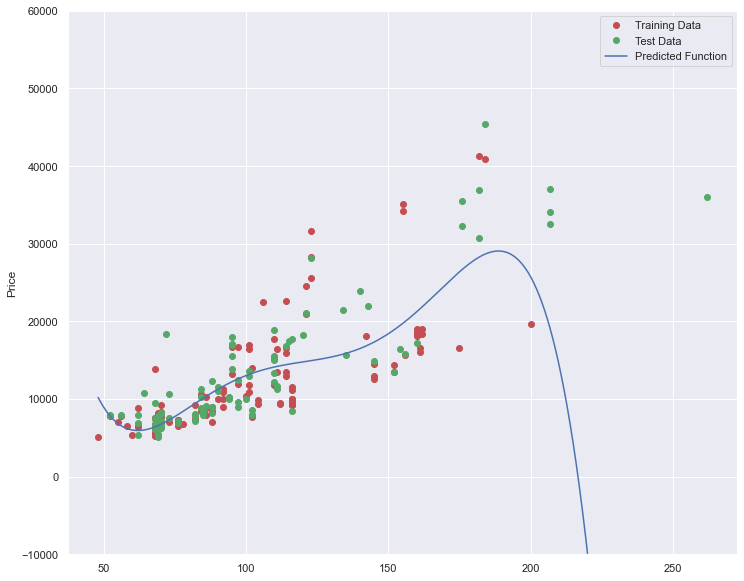

In [30]:
PollyPlot(X_train[['horsepower']], X_test[['horsepower']], y_train, y_test, poly,pr)

Figur 4 A polynomial regression model, red dots represent training data, green dots represent test data, and the blue line represents the model prediction. 


We see that the estimated function appears to track the data but around 200 horsepower, the function begins to diverge from the data points. 


 R^2 of the training data:


In [31]:
poly.score(X_train_pr, y_train)

0.5567716902635091

 R^2 of the test data:


In [32]:
poly.score(X_test_pr, y_test)

-29.871418859187518

We see the R^2 for the training data is 0.5567 while the R^2 on the test data was -29.87.  The lower the R^2, the worse the model, a Negative R^2 is a sign of overfitting.


Let's see how the R^2 changes on the test data for different order polynomials and plot the results:


The R-square values:  [0.7325101750243117, 0.7405858710699834, 0.7406204232772, 0.40639663699026196, -29.871418859187518]


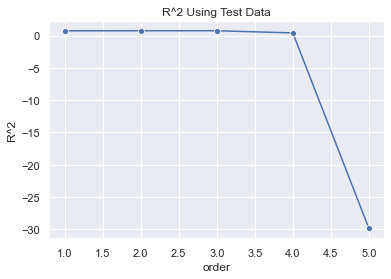

In [33]:
Rsqu_test = []

order = [1, 2, 3, 4, 5]
for n in order:
    pr = PolynomialFeatures(degree=n)
    
    x_train_pr = pr.fit_transform(X_train[['horsepower']])
    
    x_test_pr = pr.fit_transform(X_test[['horsepower']])    
    
    lr.fit(x_train_pr, y_train)
    
    Rsqu_test.append(lr.score(x_test_pr, y_test))

print("The R-square values: ", Rsqu_test);

sns.lineplot(x=order, y=Rsqu_test, markers=True, marker='o')
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 Using Test Data');

We see the R^2 gradually increases until an order three polynomial is used. Then the  R^2 dramatically decreases at four.

So, what we can tell is that a model with a degree of 1 would be too loosely fitted (or underfitted) and a model of degree such as 5 would be too overfitted. Selecting the right method requires some experimentaion and getting the values. 

# Author
By Abhinav Garg